# Домашнее задание №6: «Каракули и нейросети» [\[link\]](http://mit.spbau.ru/sewiki/images/a/ad/ML17-Homework6.pdf)

## Data

In [1]:
import scipy.io
from urllib.request import urlretrieve
from os.path import isfile
from sklearn.model_selection import train_test_split

DATASET_URL = "https://github.com/amplab/datascience-sp14" \
              "/raw/master/lab7/mldata/mnist-original.mat"
DATASET_FILE = "mnist-original.mat"
TEST_SIZE = 0.3

if not isfile(DATASET_FILE):
    urlretrieve(DATASET_URL, DATASET_FILE)
dataset = scipy.io.loadmat(DATASET_FILE)
X_train, X_test, Y_train, Y_test = train_test_split(dataset['data'].T / 255.0,
                                                    dataset['label'].squeeze().astype("int0"),
                                                    test_size=TEST_SIZE)

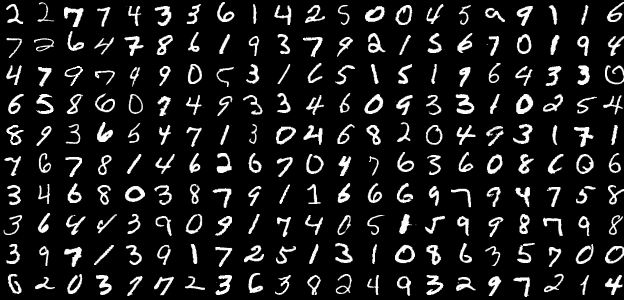

In [2]:
from visualize import visualize_mnist
from IPython.display import display, Image

VISUALIZE_FILE = "mnist.png"

image = visualize_mnist(X_train, filename=VISUALIZE_FILE)
image.crop((0, 0, 624, 300))

## Useful funcs

In [3]:
from itertools import tee


def pairwise(iterable):
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)


def onehot(n, k):
    a = np.zeros(n)
    a[k] = 1
    return a

## NN implementation

In [4]:
import numpy as np
from scipy.special import expit as sigmoid
from itertools import islice, chain


class NeuralNetwork:
    def __init__(self, layers):
        self.num_layers = len(layers)
        self.layers = layers
        self.weights = None

    def train(self, X, Y, max_iter=10000, learning_rate=1):
        Y = np.apply_along_axis(lambda y: onehot(self.layers[-1], y), 1, Y[None].T)
        n, m = X.shape
        self.weights = [np.random.uniform(-1. / (2 * m), 1. / (2 * m),
                        (b, a + 1)) for a, b in pairwise(self.layers)]
        for _ in range(max_iter):
            i = np.random.randint(n)
            x, y = X[i], Y[i]
            A = self.forward(x)
            E = self.backward(y, A)
            for e, a, u, W in zip(E, A, chain([x], A[:-1]), self.weights):
                W -= learning_rate * ((e * a * (1 - a))[None].T @ np.hstack((-1, u))[None])

    def forward(self, x):
        A, a = [], x
        for W in self.weights:
            a = sigmoid(W @ np.hstack((-1, a)))
            A.append(a)
        return A

    def backward(self, y, A):
        E, e = [], A[-1] - y
        E.append(e)
        for a, W in zip(reversed(A), reversed(self.weights[1:])):
            e = (e * a * (1 - a)) @ W[:, 1:]
            E.append(e)
        return list(reversed(E))

    def predict(self, X):
        return np.apply_along_axis(lambda x: self.forward(x)[-1].argmax(), 1, X)

## Test

In [5]:
nn = NeuralNetwork([X_train.shape[1], 100, 10])
nn.train(X_train, Y_train)

In [6]:
(nn.predict(X_test) == Y_test).sum() / len(Y_test)

0.91066666666666662

## Q&A

* **Как меняется качество классификации при изменении количества
слоев сети и количества нейронов на каждом слое?**

	С увеличением количества слоев - однозначно, ухудшается. С ростом количества нейронов на слое - как минимум, не улучшается (главное не выбрать слишком мало).